#Import library

In [71]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

df_raw = pd.read_csv("raw_house_data.csv")
print("Raw shape:", df_raw.shape)
print(df_raw.dtypes)

Raw shape: (5000, 16)
MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms           float64
sqrt_ft             float64
garage              float64
kitchen_features     object
fireplaces           object
floor_covering       object
HOA                  object
dtype: object


#Load data and basic cleaning

In [72]:
def prepare_df(df):
    df = df.copy()

    # Cast numeric-like object columns
    numeric_obj_cols = ["bathrooms", "sqrt_ft", "garage", "fireplaces", "HOA"]
    for col in numeric_obj_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Required columns
    required_cols = [
        "sold_price", "sqrt_ft", "lot_acres", "taxes",
        "longitude", "latitude", "year_built",
        "bedrooms", "bathrooms", "zipcode"
    ]
    for col in required_cols:
        df = df[df[col].notna()]

    # Remove impossible values
    df = df[(df["sold_price"] > 0) & (df["sqrt_ft"] > 0)]

    # Fill optional numeric fields
    df["garage"]     = df["garage"].fillna(0)
    df["fireplaces"] = df["fireplaces"].fillna(0)
    df["HOA"]        = df["HOA"].fillna(0)

    df = df.reset_index(drop=True)

    # Clip taxes at 1%–99% to reduce outlier impact
    lower_t = df["taxes"].quantile(0.01)
    upper_t = df["taxes"].quantile(0.99)
    df["taxes"] = df["taxes"].clip(lower=lower_t, upper=upper_t)

    return df, lower_t, upper_t

df, taxes_low, taxes_high = prepare_df(df_raw)
print("After cleaning:", df.shape)
print(f"Taxes clipped to [{taxes_low:.2f}, {taxes_high:.2f}]")

After cleaning: (4944, 16)
Taxes clipped to [483.44, 20507.84]


#Create price_per_sqrt and est_tax_rate

In [73]:
df["rooms"] = df["bedrooms"] + df["bathrooms"]      # we will use this in KNN
df["price_per_sqrt"] = df["sold_price"] / df["sqrt_ft"]
df["est_tax_rate"]   = df["taxes"] / df["sold_price"]

In [74]:
df["est_tax_rate"].describe()

,est_tax_rate
count,4944.000000
mean,0.008964
std,0.003234
min,0.000312
25%,0.007399
50%,0.009116
75%,0.010694
max,0.037287


#KNN smoothing helper

In [75]:
def knn_smooth_all(df, feature_cols, value_col, k=60):
    X = df[feature_cols].values.astype(float)
    v = df[value_col].values.astype(float)

    mean = X.mean(axis=0)
    std  = X.std(axis=0)
    std[std == 0] = 1.0

    Z = (X - mean) / std   # standardized

    N = Z.shape[0]
    smoothed = np.zeros(N, dtype=float)

    for i in range(N):
        z = Z[i]
        d2 = np.sum((Z - z)**2, axis=1)
        d2[i] = np.inf
        k_eff = min(k, N-1)
        nn_idx = np.argpartition(d2, k_eff)[:k_eff]
        smoothed[i] = v[nn_idx].mean()

    return smoothed, mean, std, Z

# KNN feature vector WITHOUT sold_price
region_feat_cols = ["longitude", "latitude", "sqrt_ft", "rooms", "lot_acres"]

# Smooth price_per_sqrt & tax_rate using neighbours defined by (lon, lat, sqrt_ft, rooms, lot_acres)
df["region_price_per_sqrt"], r_mean, r_std, region_Z = knn_smooth_all(
    df, region_feat_cols, "price_per_sqrt", k=60
)
df["region_tax_rate"], _, _, _ = knn_smooth_all(
    df, region_feat_cols, "est_tax_rate", k=60
)

# Save base arrays for new-house prediction
region_base_price   = df["price_per_sqrt"].values.astype(float)
region_base_taxrate = df["est_tax_rate"].values.astype(float)

#Region features (KNN-based)

In [76]:
q1, q2 = np.quantile(df["region_price_per_sqrt"].values, [1/3, 2/3])

def region_cat(v):
    if v <= q1:
        return 0
    elif v <= q2:
        return 1
    else:
        return 2

df["cat"] = df["region_price_per_sqrt"].apply(region_cat).astype(int)

In [77]:
df

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,...,kitchen_features,fireplaces,floor_covering,HOA,rooms,price_per_sqrt,est_tax_rate,region_price_per_sqrt,region_tax_rate,cat
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272.0000,1941,13,10.0,...,"Dishwasher, Freezer, Refrigerator, Oven",6.0,"Mexican Tile, Wood",0.0,23.0,504.761905,0.000995,259.212673,0.008068,2
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422.3600,1997,2,2.0,...,"Dishwasher, Garbage Disposal",5.0,"Natural Stone, Other",0.0,4.0,575.342466,0.002482,273.516118,0.008043,2
2,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.5800,1930,7,5.0,...,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4.0,"Ceramic Tile, Laminate, Wood",0.0,12.0,498.946668,0.001871,244.005109,0.009145,2
3,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.0000,1995,4,6.0,...,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5.0,"Carpet, Concrete",55.0,10.0,533.372420,0.004512,208.782360,0.010417,1
4,21528016,3250000.0,85718,-110.910593,32.339090,1.67,20507.8406,1999,3,4.0,...,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5.0,"Natural Stone, Wood, Other",422.0,7.0,475.007308,0.006310,206.847063,0.011309,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,21810382,495000.0,85641,-110.661829,31.907917,4.98,2017.0000,2005,5,3.0,...,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1.0,"Carpet, Ceramic Tile",0.0,8.0,137.461816,0.004075,172.193545,0.009740,0
4940,21908591,550000.0,85750,-110.858556,32.316373,1.42,4822.0100,1990,4,3.0,...,"Dishwasher, Double Sink, Electric Range, Garba...",1.0,"Carpet, Ceramic Tile",43.0,7.0,237.273512,0.008767,237.812538,0.007536,2
4941,21832452,475000.0,85192,-110.755428,32.964708,12.06,1000.0000,1969,3,2.0,...,"Dishwasher, Electric Range, Island, Refrigerat...",0.0,Ceramic Tile,0.0,5.0,268.058691,0.002105,233.651390,0.006328,2
4942,21900515,550000.0,85745,-111.055528,32.296871,1.01,5822.9300,2009,4,4.0,...,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1.0,"Carpet, Ceramic Tile",0.0,8.0,147.690655,0.010587,178.850047,0.010234,0


# Kitchen & floor compact features

In [78]:
df["kitchen_features"] = df["kitchen_features"].fillna("None").astype(str)
df["floor_covering"]   = df["floor_covering"].fillna("None").astype(str)

def parse_kitchen_flags(s: str):
    parts = [p.strip().lower() for p in s.split(",")]
    real = [p for p in parts if p and p != "none"]
    flags = {
        "kitchen_count": float(len(real)),
        "kitchen_has_dishwasher": 0.0,
        "kitchen_has_disposal":   0.0,
        "kitchen_has_fridge":     0.0,
        "kitchen_has_oven":       0.0,
        "kitchen_has_microwave":  0.0,
        "kitchen_has_pantry":     0.0,
    }
    for p in parts:
        if "dishwasher" in p:
            flags["kitchen_has_dishwasher"] = 1.0
        if "garbage disposal" in p or "disposal" in p:
            flags["kitchen_has_disposal"] = 1.0
        if "refrigerator" in p or "fridge" in p:
            flags["kitchen_has_fridge"] = 1.0
        if "oven" in p:
            flags["kitchen_has_oven"] = 1.0
        if "microwave" in p:
            flags["kitchen_has_microwave"] = 1.0
        if "pantry" in p:
            flags["kitchen_has_pantry"] = 1.0
    return pd.Series(flags)

def parse_floor_flags(s: str):
    parts = [p.strip().lower() for p in s.split(",")]
    flags = {
        "floor_has_carpet":   0.0,
        "floor_has_tile":     0.0,
        "floor_has_wood":     0.0,
        "floor_has_concrete": 0.0,
        "floor_has_stone":    0.0,
        "floor_has_laminate": 0.0,
        "floor_has_other":    0.0,
    }
    for p in parts:
        if "carpet" in p:
            flags["floor_has_carpet"] = 1.0
        if "tile" in p:
            flags["floor_has_tile"] = 1.0
        if "wood" in p:
            flags["floor_has_wood"] = 1.0
        if "concrete" in p:
            flags["floor_has_concrete"] = 1.0
        if "stone" in p or "rock" in p:
            flags["floor_has_stone"] = 1.0
        if "laminate" in p:
            flags["floor_has_laminate"] = 1.0
        if ("other" in p) or (
            p not in ("carpet", "tile", "wood", "concrete", "stone", "rock", "laminate", "none")
            and p != ""
        ):
            flags["floor_has_other"] = 1.0
    return pd.Series(flags)

kflags = df["kitchen_features"].apply(parse_kitchen_flags)
fflags = df["floor_covering"].apply(parse_floor_flags)

df = pd.concat([df, kflags, fflags], axis=1)
kitchen_feature_cols = list(kflags.columns)
floor_feature_cols   = list(fflags.columns)


#Numeric feature engineering

In [79]:
df["log_sqrt_ft"]   = np.log1p(df["sqrt_ft"])
df["log_lot_acres"] = np.log1p(df["lot_acres"])
df["age"]           = 2025 - df["year_built"]
df["beds_baths"]    = df["bedrooms"] * df["bathrooms"]
df["garage_flag"]   = (df["garage"] > 0).astype(float)
df["hoa_flag"]      = (df["HOA"] > 0).astype(float)

eps = 1e-3
lot_nonzero = df["lot_acres"].copy()
lot_nonzero[lot_nonzero <= 0] = eps

df["bed_bath_interaction"] = df["bedrooms"] * df["bathrooms"]
df["log_area_density"]     = np.log1p(df["sqrt_ft"] / lot_nonzero)
df["sqrt_acres"]           = np.sqrt(np.clip(df["lot_acres"], a_min=0, a_max=None))

# Region-based transforms (do NOT need sold_price of new house)
df["log_region_price"]         = np.log(df["region_price_per_sqrt"])
df["sqrt_region_price"]        = np.sqrt(df["region_price_per_sqrt"])
df["region_tax_intensity"]     = df["region_tax_rate"] * df["region_price_per_sqrt"]  # optional combo

df["log_taxes"] = np.log1p(df["taxes"])

#Final feature list

In [80]:
base_feature_cols = [
    # Structural & size
    "log_sqrt_ft",
    "log_lot_acres",
    "age",
    "bedrooms",
    "bathrooms",
    "rooms",
    "beds_baths",
    "garage",
    "garage_flag",
    "fireplaces",
    "HOA",
    "hoa_flag",

    # Location
    "longitude",
    "latitude",
    "zipcode",

    # Region-level features
    "region_price_per_sqrt",
    "region_tax_rate",
    "region_tax_intensity",
    "cat",
    "log_region_price",
    "sqrt_region_price",

    # Other interactions
    "bed_bath_interaction",
    "log_area_density",
    "sqrt_acres",
] + kitchen_feature_cols + floor_feature_cols

feature_cols = base_feature_cols
target_log  = "log_taxes"
target_raw  = "taxes"

#Build clean data matrix (remove NaN/inf)

In [81]:
data = df[feature_cols + [target_log, target_raw]].replace([np.inf, -np.inf], np.nan)
before = len(data)
data = data.dropna().reset_index(drop=True)
after = len(data)
print(f"Rows before dropna: {before}, after dropna: {after}")

Rows before dropna: 4944, after dropna: 4944


#Train / Val / Test split (70 / 15 / 15)

In [82]:
np.random.seed(42)
N = len(data)
indices = np.random.permutation(N)

train_end = int(0.7 * N)
val_end   = int(0.85 * N)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

train = data.iloc[train_idx]
val   = data.iloc[val_idx]
test  = data.iloc[test_idx]

X_train = train[feature_cols].values.astype(float)
y_train_log = train[target_log].values.astype(float)
y_train     = train[target_raw].values.astype(float)

X_val = val[feature_cols].values.astype(float)
y_val_log = val[target_log].values.astype(float)
y_val     = val[target_raw].values.astype(float)

X_test = test[feature_cols].values.astype(float)
y_test_log = test[target_log].values.astype(float)
y_test     = test[target_raw].values.astype(float)

#Standardize features (based on TRAIN only)

In [83]:
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)
std[std == 0] = 1.0

X_train_s = (X_train - mean) / std
X_val_s   = (X_val   - mean) / std
X_test_s  = (X_test  - mean) / std

#Implement OLS (Closed-Form) and Metrics

In [84]:
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def fit_ols(X, y):
    Xb = add_bias(X)
    XtX = Xb.T @ Xb
    theta = np.linalg.pinv(XtX) @ Xb.T @ y
    return theta

def predict_ols(X, theta):
    return add_bias(X) @ theta

def regression_metrics(y_true, y_pred):
    mse = float(np.mean((y_true - y_pred)**2))
    rmse = sqrt(mse)
    mae = float(np.mean(np.abs(y_true - y_pred)))
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - y_true.mean())**2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return mae, rmse, r2

##Train the OLS model (on log_taxes)

In [85]:
theta_new = fit_ols(X_train_s, y_train_log)

y_train_pred_log = predict_ols(X_train_s, theta_new)
y_val_pred_log   = predict_ols(X_val_s,   theta_new)
y_test_pred_log  = predict_ols(X_test_s,  theta_new)

print("=== New Model: Metrics in log(taxes) space ===")
print("Train:", regression_metrics(y_train_log, y_train_pred_log))
print("Val  :", regression_metrics(y_val_log,   y_val_pred_log))
print("Test :", regression_metrics(y_test_log,  y_test_pred_log))

=== New Model: Metrics in log(taxes) space ===
Train: (0.3042838898270908, 0.45986733825895676, 0.37986798789480636)
Val  : (0.297948115122044, 0.4573515902254625, 0.38694393667619875)
Test : (0.2934303039568958, 0.45101953694230207, 0.3369920651407621)


#Evaluate in original taxes space

In [86]:
y_train_pred = np.expm1(y_train_pred_log)
y_val_pred   = np.expm1(y_val_pred_log)
y_test_pred  = np.expm1(y_test_pred_log)

print("\n=== New Model: Metrics in original taxes space ===")
train_mae_new, train_rmse_new, train_r2_new = regression_metrics(y_train, y_train_pred)
val_mae_new,   val_rmse_new,   val_r2_new   = regression_metrics(y_val,   y_val_pred)
test_mae_new,  test_rmse_new,  test_r2_new  = regression_metrics(y_test,  y_test_pred)

print("Train:", (train_mae_new, train_rmse_new, train_r2_new))
print("Val  :", (val_mae_new,   val_rmse_new,   val_r2_new))
print("Test :", (test_mae_new,  test_rmse_new,  test_r2_new))


=== New Model: Metrics in original taxes space ===
Train: (1749.198007477188, 2446.3032238560095, 0.4876715940479862)
Val  : (1656.3779240800677, 2257.398733831195, 0.546530648364367)
Test : (1728.3914197729034, 2467.6154065604687, 0.4513380521964224)


#Predicting Taxes for a New House

In [87]:
def predict_taxes_for_house(house, k=60):
    """
    Predict taxes for a new house.
    IMPORTANT: No sold_price required in input.

    house: dict with keys:
      sqrt_ft, lot_acres, year_built,
      bedrooms, bathrooms, garage, fireplaces, HOA,
      longitude, latitude, zipcode,
      kitchen_features, floor_covering
    """
    row = pd.DataFrame([house])

    # numeric conversions
    for col in [
        "sqrt_ft", "lot_acres", "year_built",
        "bedrooms", "bathrooms", "garage", "fireplaces", "HOA",
        "longitude", "latitude", "zipcode"
    ]:
        row[col] = pd.to_numeric(row[col], errors="coerce")

    row["garage"]     = row["garage"].fillna(0)
    row["fireplaces"] = row["fireplaces"].fillna(0)
    row["HOA"]        = row["HOA"].fillna(0)

    # rooms
    row["rooms"] = row["bedrooms"] + row["bathrooms"]

    # structural numeric features
    row["log_sqrt_ft"]   = np.log1p(row["sqrt_ft"])
    row["log_lot_acres"] = np.log1p(row["lot_acres"])
    row["age"]           = 2025 - row["year_built"]
    row["beds_baths"]    = row["bedrooms"] * row["bathrooms"]
    row["garage_flag"]   = (row["garage"] > 0).astype(float)
    row["hoa_flag"]      = (row["HOA"] > 0).astype(float)

    lot = float(row["lot_acres"].iloc[0])
    if lot <= 0:
        lot = 1e-3
    row["bed_bath_interaction"] = row["bedrooms"] * row["bathrooms"]
    row["log_area_density"]     = np.log1p(row["sqrt_ft"] / lot)
    row["sqrt_acres"]           = np.sqrt(row["lot_acres"])

    # === KNN region smoothing WITHOUT sold_price ===
    new_region_input = np.array([
        row["longitude"].iloc[0],
        row["latitude"].iloc[0],
        row["sqrt_ft"].iloc[0],
        row["rooms"].iloc[0],
        row["lot_acres"].iloc[0],
    ], dtype=float)

    z_new = (new_region_input - r_mean) / r_std
    d2 = np.sum((region_Z - z_new)**2, axis=1)
    k_eff = min(k, len(region_Z) - 1)
    nn_idx = np.argpartition(d2, k_eff)[:k_eff]

    # Regional smoothed signals from neighbours (training data)
    region_pps     = region_base_price[nn_idx].mean()      # price_per_sqrt neighbours
    region_taxrate = region_base_taxrate[nn_idx].mean()    # tax_rate neighbours

    row["region_price_per_sqrt"] = region_pps
    row["region_tax_rate"]       = region_taxrate
    row["region_tax_intensity"]  = region_pps * region_taxrate

    # cat: region tier
    v = region_pps
    if v <= q1:
        row["cat"] = 0
    elif v <= q2:
        row["cat"] = 1
    else:
        row["cat"] = 2

    row["log_region_price"]  = np.log(region_pps)
    row["sqrt_region_price"] = np.sqrt(region_pps)

    # kitchen & floor flags
    k_str = str(house.get("kitchen_features", "None") or "None")
    f_str = str(house.get("floor_covering", "None") or "None")

    k_ser = parse_kitchen_flags(k_str)
    f_ser = parse_floor_flags(f_str)

    for col in kitchen_feature_cols:
        row[col] = float(k_ser[col])
    for col in floor_feature_cols:
        row[col] = float(f_ser[col])

    # Final feature vector
    X_new = row[feature_cols].values.astype(float)
    X_new_s = (X_new - mean) / std

    log_tax_pred = predict_ols(X_new_s, theta_new)
    tax_pred = float(np.expm1(log_tax_pred)[0])
    return tax_pred

In [88]:
# Example usage
example_house_no_price = {
    "sqrt_ft": 2200,
    "lot_acres": 0.25,
    "year_built": 2001,
    "bedrooms": 3,
    "bathrooms": 2,
    "garage": 2,
    "fireplaces": 1,
    "HOA": 150,
    "longitude": -110.9,
    "latitude": 32.25,
    "zipcode": 85718,
    "kitchen_features": "Dishwasher, Refrigerator, Oven",
    "floor_covering": "Wood, Tile",
}

print("Predicted taxes:",
      predict_taxes_for_house(example_house_no_price))

Predicted taxes: 3810.3396555676404


In [89]:
#cat 0
example_cat0 = {
    "sqrt_ft": 1300,
    "lot_acres": 0.12,
    "year_built": 1984,
    "bedrooms": 2,
    "bathrooms": 1,
    "garage": 0,
    "fireplaces": 0,
    "HOA": 0,
    "longitude": -111.02,
    "latitude": 31.92,
    "zipcode": 85635,
    "kitchen_features": "Dishwasher",
    "floor_covering": "Carpet"
}

In [90]:
example_cat1 = {
    "sqrt_ft": 2200,
    "lot_acres": 0.25,
    "year_built": 2003,
    "bedrooms": 3,
    "bathrooms": 2,
    "garage": 2,
    "fireplaces": 1,
    "HOA": 150,
    "longitude": -110.9,
    "latitude": 32.25,
    "zipcode": 85718,
    "kitchen_features": "Dishwasher, Refrigerator, Oven",
    "floor_covering": "Wood, Tile"
}

In [91]:
example_cat2 = {
    "sqrt_ft": 4200,
    "lot_acres": 0.70,
    "year_built": 2016,
    "bedrooms": 5,
    "bathrooms": 4,
    "garage": 3,
    "fireplaces": 2,
    "HOA": 350,
    "longitude": -110.78,
    "latitude": 32.32,
    "zipcode": 85750,
    "kitchen_features": "Dishwasher, Refrigerator, Oven, Microwave, Pantry",
    "floor_covering": "Tile, Wood"
}

In [92]:
print("CAT 0 predicted:", predict_taxes_for_house(example_cat0))
print("CAT 1 predicted:", predict_taxes_for_house(example_cat1))
print("CAT 2 predicted:", predict_taxes_for_house(example_cat2))

CAT 0 predicted: 1329.3725191634605
CAT 1 predicted: 3811.1417492410333
CAT 2 predicted: 6153.006700843343


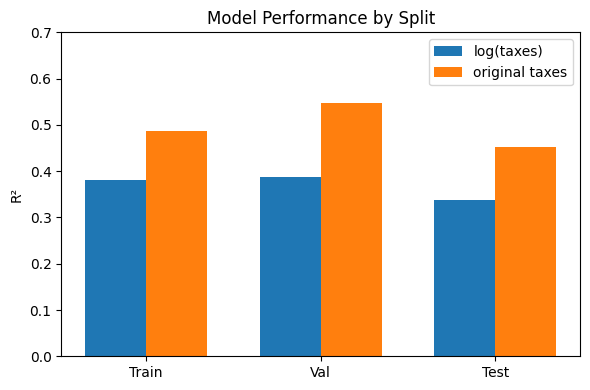

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Hard-code your final metrics here ----
r2_log = {
    "Train": 0.3799,
    "Val":   0.3869,
    "Test":  0.3370,
}

r2_orig = {
    "Train": 0.4877,
    "Val":   0.5465,
    "Test":  0.4513,
}

splits = list(r2_log.keys())
x = np.arange(len(splits))
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x - width/2, [r2_log[s] for s in splits], width, label="log(taxes)")
ax.bar(x + width/2, [r2_orig[s] for s in splits], width, label="original taxes")

ax.set_ylabel("R²")
ax.set_title("Model Performance by Split")
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_ylim(0, 0.7)
ax.legend()

plt.tight_layout()
plt.show()

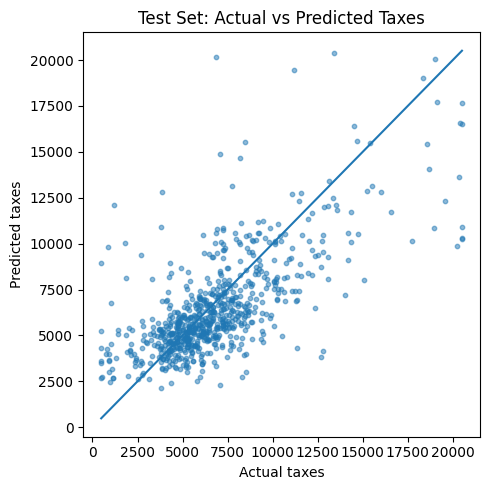

In [94]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(y_test, y_test_pred, s=10, alpha=0.5)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax.plot([min_val, max_val], [min_val, max_val])  # y = x line

ax.set_xlabel("Actual taxes")
ax.set_ylabel("Predicted taxes")
ax.set_title("Test Set: Actual vs Predicted Taxes")

plt.tight_layout()
plt.show()